Deal with unlabeled bbox (remove car IDs)
Goal: associate measurements to unique objects
1. remove car labels
2. formulate MILP

In [1]:
from utils import *
import importlib
import utils
importlib.reload(utils)
import os.path
from os import path
import pandas as pd
import utils_optimization as opt
importlib.reload(opt)
import time
from scipy.optimize import minimize,NonlinearConstraint,leastsq,fmin_slsqp,least_squares
import numpy.linalg as LA
from shapely.geometry import Polygon


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [71]:
# load data and remove car ID
data_path = pathlib.Path().absolute().joinpath('../2D-3D May 2021')
file_name = data_path.joinpath('record_p2c4_00001_track_outputs_corrected_3D.csv')
df = utils.read_data(file_name,0)

path_vpts = data_path.joinpath('camera_calibration_points_I24_validation_system.csv')
print('Transform from image to gps...')
df = utils.img_to_gps(df, 'P2C4', path_vpts) # transform from pixel to gps coordinates
A = [36.004654, -86.609976] # south west side, so that x, y coords obey counterclockwise
B = [36.002114, -86.607129]
print('Transform from gps to road...')
df = utils.gps_to_road_df(df)
print('Get x direction...')
df = utils.get_x_direction(df)
print('Naive filter...')
df = utils.naive_filter_3D(df)
xmin,xmax,ymin,ymax = utils.get_xy_minmax(df)
global xmin, xmax, ymin, ymax
# select only the first 200 rows for trial
# df = df[df['Frame #']<=100]
# nO = len(df.groupby('ID'))
# df = df.drop(['ID'],axis=1)
# print(nO,' unique cars')
print(len(df))
df

Transform from image to gps...
Transform from gps to road...
Get x direction...
Naive filter...


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:182: RuntimeWarning: invalid value encountered in greater
  outliers = np.logical_or(w1>5, w2>5)
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:190: RuntimeWarning: invalid value encountered in greater
  outliers =	abs(l1 - m1) > 2 * s1


5407


Frame #     Timestamp      ID Object class    BBox xmin    BBox ymin  \
0          65  1.754433e+09     261       pickup  3484.000000   686.000000   
1          66           NaN     261       pickup  3424.666667   686.666667   
2          67           NaN     261       pickup  3365.333333   687.333333   
3          68           NaN     261       pickup  3306.000000   688.000000   
4          69           NaN     261       pickup  3246.666667   688.666667   
...       ...           ...     ...          ...          ...          ...   
5402     1952           NaN  230261      midsize  3941.146484  1624.095581   
5403     1953           NaN  230261      midsize  3958.749756  1640.937256   
5404     1954           NaN  230261      midsize  3976.840332  1656.939575   
5405     1955           NaN  230261      midsize  3983.600586  1676.119019   
5406     1956           NaN  230261      midsize  3996.033447  1691.113281   

        BBox xmax    BBox ymax      vel_x      vel_y  ...     bbllon  \
0     3834.000000   838.000000 -51.490238   9.889586  ...        NaN   
1     3774.666667   838.000000 -51.490238   9.889586  ... -86.607575   
2     3715.333333   838.000000 -51.490238   9.889586  ...        NaN   
3     3656.000000   838.000000 -51.490238   9.889586  ... -86.607591   
4     3596.666667   838.000000 -51.490238   9.889586  ... -86.607599   
...           ...          ...        ...        ...  ...        ...   
5402  3957.697998  1692.516235  17.529963  11.881340  ...        NaN   
5403  3969.719971  1691.865601  18.557230  12.814673  ...        NaN   
5404  3982.888916  1691.955200  19.086403  13.402065  ...        NaN   
5405  3990.562744  1698.806152  12.432745  14.994257  ...        NaN   
5406  3997.595215  1702.645386  12.432745  14.994257  ...        NaN   

           bbr_x      bbr_y       fbr_x      fbr_y       fbl_x      fbl_y  \
0            NaN        NaN         NaN        NaN         NaN        NaN   
1     286.634989  33.297681  280.937256  33.315174  281.069620  31.521108   
2            NaN        NaN         NaN        NaN         NaN        NaN   
3     284.394542  33.244571  278.893401  33.323290  280.201705  31.553031   
4     283.446562  33.102469  277.751315  33.177306  277.866267  31.574085   
...          ...        ...         ...        ...         ...        ...   
5402         NaN        NaN         NaN        NaN         NaN        NaN   
5403         NaN        NaN         NaN        NaN         NaN        NaN   
5404         NaN        NaN         NaN        NaN         NaN        NaN   
5405         NaN        NaN         NaN        NaN         NaN        NaN   
5406         NaN        NaN         NaN        NaN         NaN        NaN   

           bbl_x      bbl_y  direction  
0            NaN        NaN       -1.0  
1     286.792874  31.566399       -1.0  
2            NaN        NaN       -1.0  
3     284.629042  31.598340       -1.0  
4     283.530932  31.618767       -1.0  
...          ...        ...        ...  
5402         NaN        NaN        1.0  
5403         NaN        NaN        1.0  
5404         NaN        NaN        1.0  
5405         NaN        NaN        1.0  
5406         NaN        NaN        1.0  

[5407 rows x 46 columns]

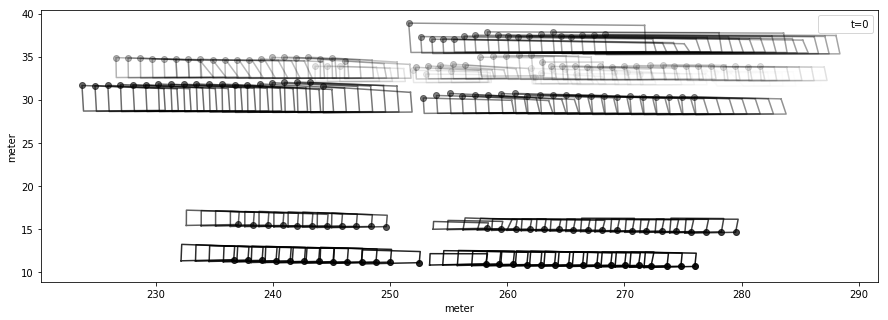

In [75]:
# try known number of objects
# plot 
import utils
importlib.reload(utils)
D = np.array(df[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
utils.plot_track(D,15,5)

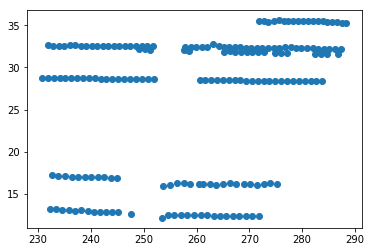

In [76]:
plt.scatter(df['bbl_x'],df['bbl_y'])
plt.show()

In [72]:
df = df.head(200)
df

Frame #     Timestamp    ID   Object class    BBox xmin   BBox ymin  \
0         65  1.754433e+09   261         pickup  3484.000000  686.000000   
1         66           NaN   261         pickup  3424.666667  686.666667   
2         67           NaN   261         pickup  3365.333333  687.333333   
3         68           NaN   261         pickup  3306.000000  688.000000   
4         69           NaN   261         pickup  3246.666667  688.666667   
..       ...           ...   ...            ...          ...         ...   
195       15  1.754432e+09  4261  truck (other)  3005.979248  723.948914   
196       16  1.754432e+09  4261  truck (other)  2945.922607  731.941528   
197       17  1.754432e+09  4261  truck (other)  2879.591064  733.551453   
198       18  1.754432e+09  4261  truck (other)  2811.612061  737.525330   
199       19  1.754432e+09  4261  truck (other)  2740.375977  740.011292   

       BBox xmax   BBox ymax      vel_x     vel_y  ...     bbllon       bbr_x  \
0    3834.000000  838.000000 -51.490238  9.889586  ...        NaN         NaN   
1    3774.666667  838.000000 -51.490238  9.889586  ... -86.607575  286.634989   
2    3715.333333  838.000000 -51.490238  9.889586  ...        NaN         NaN   
3    3656.000000  838.000000 -51.490238  9.889586  ... -86.607591  284.394542   
4    3596.666667  838.000000 -51.490238  9.889586  ... -86.607599  283.446562   
..           ...         ...        ...       ...  ...        ...         ...   
195  3530.973389  956.836914 -53.225006 -2.704681  ... -86.607649  280.040131   
196  3466.830811  960.118103 -57.118340  0.522501  ... -86.607657  278.940889   
197  3397.896729  964.419739 -62.469040  0.969154  ... -86.607666  277.841768   
198  3331.812500  967.110168 -64.608803  1.671608  ... -86.607673  276.746922   
199  3259.039795  971.066895 -68.652122  1.962299  ... -86.607682  275.651355   

         bbr_y       fbr_x      fbr_y       fbl_x      fbl_y       bbl_x  \
0          NaN         NaN        NaN         NaN        NaN         NaN   
1    33.297681  280.937256  33.315174  281.069620  31.521108  286.792874   
2          NaN         NaN        NaN         NaN        NaN         NaN   
3    33.244571  278.893401  33.323290  280.201705  31.553031  284.629042   
4    33.102469  277.751315  33.177306  277.866267  31.574085  283.530932   
..         ...         ...        ...         ...        ...         ...   
195  30.105417  272.654571  30.340267  272.778455  28.264190  280.451496   
196  30.123534  271.557957  30.355503  271.680852  28.280037  279.338385   
197  30.158894  270.462321  30.385313  270.586836  28.275325  278.225928   
198  30.121409  269.343920  30.378188  269.462866  28.300981  277.140746   
199  30.146405  268.250106  30.390717  268.369420  28.303896  276.024812   

         bbl_y  direction  
0          NaN       -1.0  
1    31.566399       -1.0  
2          NaN       -1.0  
3    31.598340       -1.0  
4    31.618767       -1.0  
..         ...        ...  
195  28.349265       -1.0  
196  28.364915       -1.0  
197  28.360125       -1.0  
198  28.386112       -1.0  
199  28.388848       -1.0  

[200 rows x 46 columns]

In [146]:
def dist_score(B, B_data, DIST_MEAS='xy'):
    '''
    compute euclidean distance between B and B_data
    B: predicted bbox location
    B_data: measurement
    '''

    # average displacement RMSE of all points
    if DIST_MEAS == 'xy':
        return np.linalg.norm(B-B_data,2)
#         return np.apply_along_axis(np.linalg.norm, 1, B-B_data)

#     # x-displacement
#     elif DIST_MEAS == 'x':
#         return np.apply_along_axis(np.linalg.norm, 1, B[[0,2,4,6]]-B_data[:,[0,2,4,6]])

#     # y-displacement
#     elif DIST_MEAS == 'y':
#         return np.apply_along_axis(np.linalg.norm, 1, B[[1,3,5,7]]-B_data[:,[1,3,5,7]])

    # weighted x,y displacement, penalize y more heavily
    elif DIST_MEAS == 'xyw':
        return 0.2*np.linalg.norm(B[[0,2,4,6]]-B_data[[0,2,4,6]],2) + 0.8*np.linalg.norm(B[[1,3,5,7]]-B_data[[1,3,5,7]],2)
    
    else:
        return
    
def IOU_score(D1,D2):
    '''
    calculate the intersection of union of two boxes defined by d1 and D2
    D1: prediction box
    D2: measurement box
    https://stackoverflow.com/questions/57885406/get-the-coordinates-of-two-polygons-intersection-area-in-python
    '''
    if np.isnan(D2).any():
        return np.nan
    p = Polygon([(D1[2*i],D1[2*i+1]) for i in range(int(len(D1)/2))])
    q = Polygon([(D2[2*i],D2[2*i+1]) for i in range(int(len(D2)/2))])
    if (p.intersects(q)):
        intersection_area = p.intersection(q).area
        union_area = p.union(q).area
#         print(intersection_area, union_area)
        return float(intersection_area/union_area)
    else:
        return 0
    
def predict_tracks(tracks):
    '''
    tracks: [dictionary]. Key: car_id, value: mx8 matrix with footprint positions
    if a track has only 1 frame, make the second frame nans
    otherwise do constant-velocity one-step-forward prediction
    '''
    x = []
    for car_id, track in tracks.items():
        if len(track)>1:  
            delta = (track[-1,:] - track[0,:])/(len(track)-1)
            x_pred = track[-1,:] + delta
            tracks[car_id] = np.vstack([track, x_pred])
            x.append(x_pred) # prediction next frame, dim=nx8
        else:
#             x_pred = np.nan*np.empty((1,8)) # nan as place holder, to be interpolated
            # TODO: assume traveling 30m/s based on direction (y axis)
            x_pred = track[-1,:] # keep the last measurement
            tracks[car_id] = np.vstack([track, x_pred])
            x.append(track[-1,:]) # take the last row
#             raise Exception('must have at least 2 frames to predict')
    return x, tracks
            
def get_last_frame_pos(tracks):
    '''
    tracks: [dictionary]. Key: car_id, value: mx8 matrix with footprint positions
    '''
    x = []
    for _, track in tracks.items():
        x.append(track[-1,:]) # take the last row
    return x      

def delete_track_out_of_view(tracks,xmin=xmin,xmax=xmax):
    rem_list = []
    for car_id,track in tracks.items():
        last = track[-1,:]
        x1 = np.min(last[[0,2,4,6]])
        x2 = np.max(last[[0,2,4,6]])
#         print(x1,x2)
        if (x1>xmax) or (x2<xmin):
            print('** delete ID ', car_id, ' from tracks **')
            rem_list.append(car_id)
    [tracks.pop(key) for key in rem_list]
    return tracks

In [147]:
SCORE_THRESHOLD = 4
ns = np.amin(np.array(df[['Frame #']])) # start frame
nf = np.amax(np.array(df[['Frame #']])) # end frame
tracks = dict() # a dictionary to store existing tracks in scene TODO: delete out-of-view tracks
last_id = 0

for k in range(ns,nf):
    
    # get all measurements from current frame
    y = df.loc[(df['Frame #'] == k)] # TODO: use groupby frame to save time
    y = np.array(y[['bbr_x','bbr_y','fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
    y = y[~np.isnan(y).any(axis=1)] # remove rows with missing values (dim = mx8)
    
    m_box = len(y)
    n_car = len(tracks)
    
    if (m_box == 0) & (n_car == 0): # simply advance to the next frame
        print('[1] frame ',k,', no measurement and no tracks')
        
    elif (m_box == 0) & (n_car > 0): # if no measurements in current frame
        print('[2] frame ',k,', no measurement, simply predict')
        # make predictions to all existing tracks
        x, tracks = predict_tracks(tracks)
#         tracks = delete_track_out_of_view(tracks)
        
    elif (m_box > 0) & (n_car == 0): # create new tracks (initialize?)
        print('[3] frame ',k,', no tracks, initialize with first measurements')
        for ym in y:
            tracks[last_id] = np.reshape(ym, (1,-1))
            last_id += 1  
    
    else: # if measurement boxes exist in current frame k and tracks is not empty
        # make prediction for each track in tracks for frame k
        x, tracks = predict_tracks(tracks)
#         tracks = delete_track_out_of_view(tracks)
#         x = get_last_frame_pos(tracks)
        n_car = len(tracks)
        curr_id = list(tracks.keys()) # should be n id's 
        
        # calculate score matrix: for car out of scene, score = 99 for place holder
        score = np.ones([m_box,n_car])*99
        for m in range(m_box):
            for n in range(n_car):
#                 if n in curr_id:
                score[m,n] = dist_score(x[n],y[m],'xyw')
#                 else:
#                     score[m,n] = 99
#         if k == 89:
#             break
            
        # identify associated (m,n) pairs
        print('m:',m_box,'total car:',n_car, 'car in view:',len(curr_id))
        bool_arr = score == score.min(axis=1)[:,None]
        score =  bool_arr*score+np.invert(bool_arr)*99 # get the min of each row
        print(score)
        pairs = np.transpose(np.where(score<SCORE_THRESHOLD)) # pair if the max if score is lower than threshold
        print(pairs)
        
        # associate based on pairs!
        if len(pairs) > 0:
            print('[4a] frame ',k, len(pairs),' pairs are associated')
            for m,n in pairs:
                tracks[curr_id[n]][-1,:] = y[m] # change the last row from x_pred to ym
                
        # measurements that have no cars associated, create new object
        if len(pairs) < m_box:
#             print('pairs:',len(pairs),'measuremnts:',m_box)
            m_unassociated = list(set(np.arange(m_box)) - set(pairs[:,0]))
            print('[4b] frame ',k, len(m_unassociated),' measurements are not associated, create new')
            for m in m_unassociated:
                tracks[last_id] = np.reshape(y[m], (1,-1))
                last_id += 1
                
    

[3] frame  12 , no tracks, initialize with first measurements
m: 1 total car: 1 car in view: 1
[[0.47889862]]
[[0 0]]
[4a] frame  13 1  pairs are associated
m: 1 total car: 1 car in view: 1
[[0.05520658]]
[[0 0]]
[4a] frame  14 1  pairs are associated
m: 1 total car: 1 car in view: 1
[[0.0519231]]
[[0 0]]
[4a] frame  15 1  pairs are associated
m: 1 total car: 1 car in view: 1
[[0.0255692]]
[[0 0]]
[4a] frame  16 1  pairs are associated
m: 1 total car: 1 car in view: 1
[[0.0360221]]
[[0 0]]
[4a] frame  17 1  pairs are associated
m: 2 total car: 1 car in view: 1
[[10.46762059]
 [ 0.05647729]]
[[1 0]]
[4a] frame  18 1  pairs are associated
[4b] frame  18 1  measurements are not associated, create new
m: 2 total car: 2 car in view: 2
[[9.90000000e+01 4.60480531e-01]
 [2.26881558e-02 9.90000000e+01]]
[[0 1]
 [1 0]]
[4a] frame  19 2  pairs are associated
m: 1 total car: 2 car in view: 2
[[9.90000000e+01 9.41782158e-02]]
[[0 1]]
[4a] frame  20 1  pairs are associated
m: 1 total car: 2 car in 

m: 2 total car: 4 car in view: 4
[[99.         99.         99.          0.45254395]
 [99.         99.          1.51180893 99.        ]]
[[0 3]
 [1 2]]
[4a] frame  85 2  pairs are associated
m: 1 total car: 4 car in view: 4
[[99.         99.         99.          0.23097573]]
[[0 3]]
[4a] frame  86 1  pairs are associated
m: 1 total car: 4 car in view: 4
[[99.        99.        99.         0.1281118]]
[[0 3]]
[4a] frame  87 1  pairs are associated
m: 1 total car: 4 car in view: 4
[[99.         99.         99.          0.13706896]]
[[0 3]]
[4a] frame  88 1  pairs are associated
m: 2 total car: 4 car in view: 4
[[99.         99.          1.4526778  99.        ]
 [99.         99.         99.          0.25592748]]
[[0 2]
 [1 3]]
[4a] frame  89 2  pairs are associated
m: 2 total car: 4 car in view: 4
[[99.         99.          0.61323204 99.        ]
 [99.         99.         99.          0.51907553]]
[[0 2]
 [1 3]]
[4a] frame  90 2  pairs are associated
m: 2 total car: 4 car in view: 4
[[99.

4261 First frame: 12
2261 First frame: 18
261 First frame: 65
3261 First frame: 79


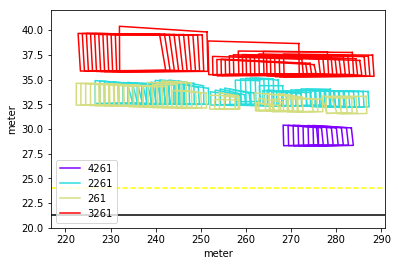

In [77]:
from matplotlib import cm
# plot dimension setup
fig, ax = plt.subplots()
plt.xlim(xmin, xmax)
plt.ylim(20, 42) # 0, 42
plt.xlabel('meter')
plt.ylabel('meter')
#plot design setup
plt.axhline(y = 21.25, color = 'black', linestyle = 'solid')
plt.axhline(y = 24, color = 'yellow', linestyle = '--')
plt.axhline(y = 18.5, color = 'yellow', linestyle = '--')
carColors=iter(cm.rainbow(np.linspace(0,1,4)))

df = df.sort_values(by=['Frame #'])
groups = df.groupby(['ID'], sort=False)
id_list = []
for carid, group in groups:
    print(carid, 'First frame:',min(group['Frame #']))
    frameSnap = np.array(group[['bbr_x','bbr_y','fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
    c = next(carColors)
    for j in range(len(frameSnap)):  # draw one vehicle onto the plot
        coord = frameSnap[j,0:8]   # Finding the coordinates of the car
        if (np.isnan(coord).any()):
            continue
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0])
        xs, ys = zip(*coord)
        plt.plot(xs,ys,c=c,label=carid if (carid not in id_list) else '')
        id_list.append(carid)
        plt.legend()
#     plt.show()
    

0
1
2
3


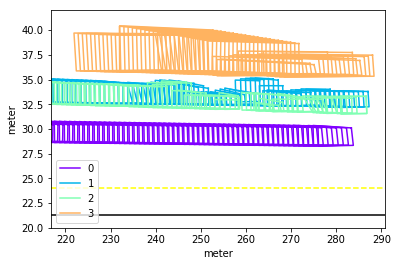

In [148]:
fig, ax = plt.subplots()
plt.xlim(xmin, xmax)
plt.ylim(20, 42) # 0, 42
plt.xlabel('meter')
plt.ylabel('meter')
#plot design setup
plt.axhline(y = 21.25, color = 'black', linestyle = 'solid')
plt.axhline(y = 24, color = 'yellow', linestyle = '--')
plt.axhline(y = 18.5, color = 'yellow', linestyle = '--')
carColors=cm.rainbow(np.linspace(0,1,5))
#     plt.figure(i+1)
# frameSnap = df.loc[(df['ID'] == 2261)]
# frameSnap = df.loc[(df['Frame #'] >= 78)&(df['Frame #'] <= 80)]
# extract the ID & road coordinates of the bottom 4 points of all vehicles at frame # i
# print(frameSnap['ID'])


# frameSnap = np.array(group[['bbr_x','bbr_y','fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
for carid, track in tracks.items():
#     if carid==6:
    print(carid)
    frameSnap = track
    c = carColors[carid%5]
    for j in range(len(frameSnap)):  # draw one vehicle onto the plot
    #     carID = int(frameSnap[j,0])  # Finding the unique carID for each vehicle in the frame
        coord = frameSnap[j,0:8]   # Finding the coordinates of the car
        if (np.isnan(coord).any()):
            print('nan')
            continue
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0])
        xs, ys = zip(*coord)
        plt.plot(xs,ys,c=c,label=carid if j==0 else '')
        #     plt.text(frameSnap[j,1], frameSnap[j,2], carID)
    plt.legend()


No handles with labels found to put in legend.


0
1


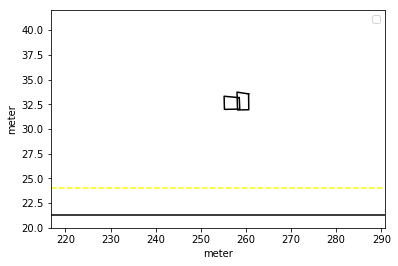

In [129]:
fig, ax = plt.subplots()
plt.xlim(xmin, xmax)
plt.ylim(20, 42) # 0, 42
plt.xlabel('meter')
plt.ylabel('meter')
#plot design setup
plt.axhline(y = 21.25, color = 'black', linestyle = 'solid')
plt.axhline(y = 24, color = 'yellow', linestyle = '--')
plt.axhline(y = 18.5, color = 'yellow', linestyle = '--')
carColors=cm.rainbow(np.linspace(0,1,5))

# frameSnap = df.loc[(df['ID'] == 2261)]
# frameSnap = df.loc[(df['Frame #'] >= 89)&(df['Frame #'] <= 89)]
# extract the ID & road coordinates of the bottom 4 points of all vehicles at frame # i
# print(frameSnap['ID'])
# frameSnap = np.array(frameSnap[['bbr_x','bbr_y','fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
frameSnap = np.vstack([x[2],y[0]])

for j in range(len(frameSnap)):  # draw one vehicle onto the plot
    print(j)
#     carID = int(frameSnap[j,0])  # Finding the unique carID for each vehicle in the frame
    coord = frameSnap[j,0:8]   # Finding the coordinates of the car
    coord = np.reshape(coord,(-1,2)).tolist()
    coord.append(coord[0])
    xs, ys = zip(*coord)
    plt.plot(xs,ys,c='black')
    #     plt.text(frameSnap[j,1], frameSnap[j,2], carID)
plt.legend()


In [124]:
x

[array([208.16254046,  30.49932528, 200.73267523,  30.92685475,
        200.77564852,  28.72437378, 208.00150927,  28.80708515]),
 array([213.26412743,  34.97641007, 208.26739094,  35.24158325,
        208.26945881,  32.70994441, 213.31385769,  32.74706977]),
 array([260.82059576,  33.54452059, 258.23075406,  33.72229828,
        258.34118094,  31.9222471 , 260.86182801,  31.94162026]),
 array([278.92982743,  37.06912786, 259.2005179 ,  37.3752312 ,
        259.29744096,  35.43389606, 279.32518266,  35.51828777])]

In [121]:
score

array([[105.18549386,  92.28794457,   5.43263537,  30.54568891],
       [130.75160125, 117.78160558,  26.80731488,   0.30504742]])

In [111]:
df.loc[(df['Frame #'] >= 88)&(df['Frame #'] <= 91)]

Frame #     Timestamp    ID   Object class    BBox xmin   BBox ymin  \
148       88           NaN  3261  truck (other)  2249.714286  419.714286   
23        88  1.754433e+09   261         pickup  2042.000000  690.000000   
137       88  1.754433e+09  2261            van  -442.287903  771.705566   
24        89  1.754433e+09   261         pickup  1976.000000  692.000000   
138       89  1.754433e+09  2261            van  -502.546387  792.592163   
149       89  1.754433e+09  3261  truck (other)  2204.000000  426.000000   
25        90  1.754433e+09   261         pickup  1924.000000  692.000000   
150       90           NaN  3261  truck (other)  2153.714286  426.000000   
151       91           NaN  3261  truck (other)  2103.428571  426.000000   
26        91  1.754433e+09   261         pickup  1866.000000  698.000000   

       BBox xmax   BBox ymax      vel_x      vel_y  ...     bbllon  \
148  3380.857143  695.428571   0.000000   0.000000  ... -86.607592   
23   2384.000000  844.000000 -72.348190  -1.391992  ...        NaN   
137  -413.373901  852.610352 -60.568008  14.929508  ...        NaN   
24   2328.000000  838.000000 -72.055420  -1.070927  ... -86.607781   
138  -488.612640  857.658813 -59.270226  16.098022  ...        NaN   
149  3328.000000  696.000000   0.000000   0.000000  ... -86.607599   
25   2268.000000  846.000000 -56.192696   0.509753  ... -86.607783   
150  3278.571429  698.000000   0.000000   0.000000  ... -86.607606   
151  3229.142857  700.000000   0.000000   0.000000  ... -86.607612   
26   2208.000000  842.000000 -55.465130   0.815269  ... -86.607784   

          bbr_x      bbr_y       fbr_x      fbr_y       fbl_x      fbl_y  \
148  279.759368  37.105224  260.030615  37.394084  260.131953  35.416940   
23          NaN        NaN         NaN        NaN         NaN        NaN   
137         NaN        NaN         NaN        NaN         NaN        NaN   
24   258.524343  33.168188  255.171327  33.309621  255.240993  31.982963   
138         NaN        NaN         NaN        NaN         NaN        NaN   
149  278.875583  37.303387  259.194754  37.529516  259.306434  35.438147   
25   258.277416  33.364583  254.068153  33.668842  254.147196  32.001924   
150  278.051614  37.793780  258.304051  37.883029  258.443943  35.460326   
151  277.045575  37.241635  257.219103  37.506404  257.322115  35.482619   
26   258.272060  32.928161  253.031742  32.980719  253.087867  31.985980   

          bbl_x      bbl_y  direction  
148  280.149142  35.501541       -1.0  
23          NaN        NaN       -1.0  
137         NaN        NaN       -1.0  
24   258.637119  32.009054       -1.0  
138         NaN        NaN       -1.0  
149  279.218954  35.521977       -1.0  
25   258.439782  32.034828       -1.0  
150  278.315433  35.543634       -1.0  
151  277.394972  35.566417       -1.0  
26   258.327354  32.026230       -1.0  

[10 rows x 46 columns]

In [40]:
# calculate the distribution of scores of the original data
carID = 230261
car = df[df['ID']==carID]
f_start = car['Frame #'].values[0] + 2
f_end = car['Frame #'].values[-1]
for k in range(f_start+20,f_start+50):
    x_prev2 = car[(car['Frame #'] >= k-1) & (car['Frame #'] <=k)] # k-1 and k
    x_prev2 = np.array(x_prev2[['bbr_x','bbr_y','fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
    x_pred = x_prev2[-1,:] + x_prev2[-1,:] - x_prev2[0,:] # k+1
    iou = []
    y_next = df[(df['Frame #'] == k+1)] # all measurements at k+1
    id_next = y_next['ID'].values
    y_next = np.array(y_next[['bbr_x','bbr_y','fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
    for i in range(len(y_next)):
        iou.append(IOU_score(x_pred, y_next[i,:]))
    scores = score(x_pred,y_next,'xy')
    print(id_next)
    print('scores:', scores)
    print('iou: ',iou)
# frames that carID is in

IllegalArgumentException: Points of LinearRing do not form a closed linestring
Shell is not a LinearRing


[230261]
scores: [0.49377669]
iou:  [0.7443470872604031]
[212261 230261]
scores: [53.09269277  0.47096816]
iou:  [0, 0.8083938310584959]
[212261 230261]
scores: [49.69589942  0.48047282]
iou:  [0, 0.900063554287454]
[212261 230261]
scores: [46.72367816  0.37460072]
iou:  [0, 0.9101096233475444]
[212261 230261]
scores: [43.21764812  0.10596647]
iou:  [0, 0.9358044433175551]
[212261 230261]
scores: [40.26311668  0.06749591]
iou:  [0, 0.958877411213823]
[212261 230261]
scores: [37.56745512  0.05706421]
iou:  [0, 0.9725153925014971]
[212261 230261]
scores: [35.29922229  0.08685668]
iou:  [0, 0.9457102331934328]
[212261 230261]
scores: [33.59492491  0.0695719 ]
iou:  [0, 0.9719665936461728]
[212261 230261]
scores: [32.48212475  0.12174321]
iou:  [0, 0.9401586123192597]
[212261 230261]
scores: [31.83416967  0.12387221]
iou:  [0, 0.9293454035798382]
[212261 230261]
scores: [32.14303018  0.21314365]
iou:  [0, 0.8959937135543852]
[212261 230261]
scores: [32.69793935  0.19826548]
iou:  [0, 0.912

ValueError: Null geometry supports no operations

In [73]:
np.amax(np.array(df[['Frame #']])) # number of frames

131

In [127]:
a = np.array([3,2,4])
a = np.reshape(a, (1,-1))
a.shape

(1, 3)

In [91]:
a = (a == a.max(axis=1)[:,None])*a
a[a<0.7] = 0
a

array([[0, 0, 4],
       [0, 0, 8]])

In [101]:
pairs = np.transpose(np.nonzero(a))
pairs

array([[0, 2],
       [1, 2]], dtype=int64)

In [102]:
pairs[:,1]

array([2, 2], dtype=int64)

In [104]:
list(set(np.arange(4)) - set(pairs[:,1]))

[0, 1, 3]